<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 1
<br>
<b>Deadline:</b> May 18, 2020 (Monday). 23:00
</div>


# Exercise 10.2. Conditional generation with PixelCNN

The goal of this exercise is to do conditional generation with the PixelCNN model.
The basic idea of the conditioning is described in Section 2.3 of [this paper](https://arxiv.org/pdf/1606.05328.pdf). However, we will use a much simpler model.

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select the device for training (use GPU if you have one)
device = torch.device('cuda:1')
#device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

# Data

In this exercise, we use standard MNIST data.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

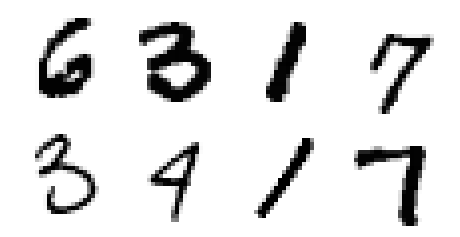

In [8]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.Greys, clim=[0,1])

# Masked convolutional layer

In the cell below, copy the implementation of the `MaskedConv2d` from the PixelCNN notebook.

In [9]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, blind_center=False):
        """
        Args:
          in_channels (int): Number of input channels.
          out_channels (int): Number of output channels.
          kernel_size (int): Kernel size similar to nn.Conv2d layer.
          blind_center (bool): If True, the kernel has zero in the center.
        """
        # YOUR CODE HERE
        super(MaskedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.blind_center = blind_center
        ch_out, ch_in, height, width = self.conv.weight.size()
        mask = torch.ones(ch_out, ch_in, height, width)
        if self.blind_center:
            mask[:, :, height // 2, width // 2:] = 0
            mask[:, :, height // 2 + 1:] = 0
        else:
            mask[:, :, height // 2, width // 2 + 1:] = 0
            mask[:, :, height // 2 + 1:] = 0
        self.register_buffer('mask', mask)
        

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, in_channels, height, width): Input images.
        
        Returns:
          y of shape (batch_size, out_channels, height, width): Output images.
        """
        # YOUR CODE HERE
        self.conv.weight.data *= self.mask
        y = self.conv.forward(x)
        return y

# Conditional PixelCNN

Conditional PixelCNN models allows to generate images of a desired class. This can be achieved by providing the desired class label to every layer of the PixelCNN model. In this notebook, we do it in the following way: the input of each masked convolutional layer is:
$$\mathbf{x} + \mathbf{W} \mathbf{h}$$
where
  * $\mathbf{x}$ is the output of the previous layer
  * $\mathbf{h}$ is a 10-dimensional one-hot coded vector of the desired class
  * $\mathbf{W}$ is $c \times 10$ matrix (parameter of a fully-connected layer), where $c$ is the number of input channels in the masked convolutional layer.

You need to implement the conditional PixelCNN model in the cell below.

Recommended architecture:
* Use an architecture similar to the PixelCNN architecture in the first notebook.

In [10]:
class ConditionalPixelCNN(nn.Module):
    def __init__(self, n_channels=64, kernel_size=7):
        """PixelCNN model for conditional generation."""
        # YOUR CODE HERE
        super(ConditionalPixelCNN, self).__init__()
        self.conv = nn.Sequential(
            MaskedConv2d(1, n_channels, kernel_size, True),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            MaskedConv2d(n_channels, n_channels, kernel_size, False),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            MaskedConv2d(n_channels, n_channels, kernel_size, False),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            MaskedConv2d(n_channels, n_channels, kernel_size, False),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            MaskedConv2d(n_channels, n_channels, kernel_size, False),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            MaskedConv2d(n_channels, n_channels, kernel_size, False),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            MaskedConv2d(n_channels, n_channels, kernel_size, False),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            MaskedConv2d(n_channels, n_channels, kernel_size, False),
            torch.nn.BatchNorm2d(n_channels),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(n_channels, 256, 1)
        )
        self.fc = nn.Linear(10, 256)
        
    def forward(self, x, labels):
        """Compute logits of the conditional probabilities p(x_i|x_1, ..., x_{i-1}) of the PixelCNN model.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Tensor of input images.
          labels of shape (batch_size): Long tensor of the desired classes of the generated samples.
        
        Returns:
          logits of shape (batch_size, 256, 28, 28): Tensor of logits of the conditional probabilities
                                                      for each pixel.
        
        NB: Do not use softmax nonlinearity after the last layer.
        """
        # YOUR CODE HERE
        expand = torch.zeros((labels.shape[0], 10)).to(device)
        expand.scatter(1, labels.unsqueeze(-1), 1)
        return self.conv(x) + self.fc(expand).repeat(1, 28 * 28).reshape(-1, 256, 28, 28)

In [11]:
def test_ConditionalPixelCNN_shapes():
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)

    batch_size = 2
    x = torch.ones(batch_size, 1, 28, 28)
    labels = torch.zeros(batch_size, dtype=torch.long)
    y = net(x, labels)
    assert y.shape == torch.Size([batch_size, 256, 28, 28]), f"Bad y.shape: {y.shape}"
    print('Success')

test_ConditionalPixelCNN_shapes()

RuntimeError: Expected object of device type cuda but got device type cpu for argument #3 'index' in call to _th_scatter_

### Loss function for training conditional PixelCNN

The `loss_fn()` function is identical to the `loss_fn()` from the PixelCNN notebook.

In [12]:
def loss_fn(logits, x):
    """Compute loss of the conditional PixelCNN model. Please see PixelCNN.loss for more details.

    Args:
      logits of shape (batch_size, 256, 28, 28): Logits of the conditional probabilities
                  p(x_i | x_1,...,x_{i-1}) of the 256 intensities of pixel x_i computed using all
                  previous pixel value x_1,...,x_{i-1}.
      x of shape (batch_size, 1, 28, 28): Images used to produce `generated_x`. The values of pixel
                  intensities in x are between 0 and 1.

    Returns:
      loss: Scalar tensor which contains the value of the loss.
    """
    # YOUR CODE HERE
    generated_x = (x[:,0] * 255).long().to(device)
    creteria = nn.CrossEntropyLoss()
    loss = creteria(logits, generated_x)
    return loss

### Generation procedure

The `generate()` function is *almost* identical to the `generate()` function from the PixelCNN notebook. It additionally receives the labels of the desired classes so that they can be used in the forward computations of the conditional PixelCNN model.

In [13]:
def generate(net, labels, image_size=(28, 28), device='cpu'):
    """Generate samples using a trained conditional PixelCNN model.
    Note: use as device labels.device.

    Args:
      net: Conditional PixelCNN model.
      labels of shape (n_samples): Long tensor of the desired classes of the generated samples.
      image_size: Tuple of image size (height, width).
      device:     Device to use.
    
    Returns:
      samples of shape (n_samples, 1, height, width): Generated samples.
    """
    # YOUR CODE HERE
    net.eval()
    n_samples = labels.shape[0]
    samples = torch.zeros((n_samples, 1, *image_size), dtype=torch.float32).to(device)
    dd = torch.arange(256).repeat((n_samples, 1)).to(device)
    for h in range(image_size[0]):
        for w in range(image_size[1]):
            res = net.forward(samples, labels)
            res = (F.softmax(res, dim=1)[:, :, h, w]).to(device)
            sa = ((res * dd).sum(1) / 255).to(device)

#             for i in range(sa.shape[0]):
#                 samples[i, 0, h, w] = sa[i]
            for i in range(sa.shape[0]):
                print(sa[i])
                samples[i, 0, h, w] = 0
    return samples

# Train the model

In [14]:
# Create network
net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
net.to(device)

ConditionalPixelCNN(
  (conv): Sequential(
    (0): MaskedConv2d(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(
      (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    

tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030,

tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.4999,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001,

tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032,

tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003,

tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5034,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5003,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5031,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5002,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032,

tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5029,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5004,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5005, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5032,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5018,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5013,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5019,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5022,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007,

tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5014, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5025,

tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5015,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016,

tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5001,

tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5016, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5027,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5020,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5010,

tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5006,

tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5021,

tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5035, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5008,

tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5028,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5009,

tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5030, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5024,

tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5026,

tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5007,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5017,

tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5012,

tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5023,

tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011, device='cuda:1', grad_fn=<SelectBackward>)
tensor(0.5011,

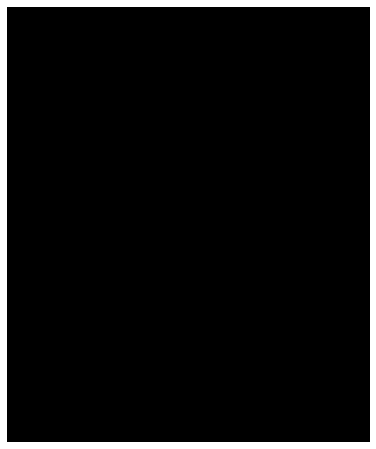

In [15]:
# Plot generated samples for an untrained model
# Note: generation on CPU may take a significant amount of time
if not skip_training:
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 11.

Hints:
- The loss values are similar to the loss values in the PixelCNN notebook.
- Please use this code to plot 120 generated samples after each epoch. This will allow you to track the training progress.
```
# Generate samples
with torch.no_grad():
    net.eval()
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)
```
- The generated images should be of great quality but you should definitely recognize the desired classes of the digits.
- **Do not forget to set the model into the training mode by `net.train()` before training.**

In [ ]:
if not skip_training:
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(net, '10_cond_pixelcnn.pth')
else:
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
    tools.load_model(net, '10_cond_pixelcnn.pth', device)

### Generate samples

In [ ]:
if not skip_training:
    with torch.no_grad():
        net.eval()
        labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
        samples = generate(net, labels, device=device)
        tools.plot_generated_samples(samples, ncol=10)

In [ ]:
# This cell tests the training loss of the trained model

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train a conditional PixelCNN model.